# E2E Latency comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_latency(filepath, warmup_steps=5):
    df = pd.read_csv(filepath)
    d = {}
    for index, row in df.iterrows():
        if row['num_objects'] not in d:
            d[row['num_objects']] = []
        d[row['num_objects']].append(row['latency'])
    avg, std = {}, {}
    for num_objects, latency in d.items():
        avg[num_objects] = pd.Series(latency[warmup_steps:]).mean()
        std[num_objects] = pd.Series(latency[warmup_steps:]).std()
    return avg, std

def get_breakdown_data(filepath, num_objects, warmup_steps=5):
    breakdown_df = pd.read_json(filepath)
    breakdown_agg = {
        "request_total_time": [],
        "token_validation_time": [],
        "history_validation_time": [],
        "policy_execution_time": [],
        "history_update_time": [],
        "resource_api_time": [],
    }
    for n in num_objects:
        d = breakdown_df[breakdown_df['history_length'] == n * 10]
        for k in breakdown_agg.keys():
            if k in d.columns:
                breakdown_agg[k].append(d.iloc[warmup_steps:][k].mean() * 1000)
    return breakdown_agg

In [3]:
def plot_latency(num_objects, avg_baseline, std_baseline, avg_stateful, std_stateful, breakdown_agg):

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar = np.array(list(avg_stateful.values()))

    # Error bars
    baseline_error = np.array(list(std_baseline.values()))  # Replace [...] with your error values for baseline_bar
    stateful_error = np.array(list(std_stateful.values()))  # Replace [...] with your error values for stateful_bar

    # Set up positions for bars
    bar_width = 0.25

    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # Add e2e latency bars
    bar1 = ax.bar(index - bar_width/2, baseline_bar, bar_width, label='OAuth E2E Latency', color="#046586")

    # Add breakdown
    network_latency = stateful_bar - breakdown_agg['request_total_time']
    # bottom = np.zeros(len(baseline_bar))
    # ax.bar(index + bar_width / 2, baseline_bar, bar_width, bottom=bottom, label=f'Baseline')
    bar3 = ax.bar(index + bar_width / 2, network_latency, bar_width, bottom=np.zeros(len(network_latency)), label=f'StatefulAuth Network Latency', color="#b22222")
    bar2 = ax.bar(index + bar_width/2, breakdown_agg['request_total_time'], bar_width, bottom=network_latency, label='StatefulAuth Server-Side Latency', color="#f4a016")

    # Move legend above the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, shadow=True, fontsize=9)

    # Add error bars
    ax.errorbar(index - bar_width/2, baseline_bar, yerr=baseline_error, fmt='none', capsize=3, color='black', label='Error Bar (OAuth)')
    ax.errorbar(index + bar_width/2, stateful_bar, yerr=stateful_error, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth)')

    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('E2E Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 600)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/e2e_latency_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()

    return fig, ax


In [4]:
def plot_breakdown(num_objects, avg_baseline, avg_stateful, breakdown_agg):

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar = np.array(list(avg_stateful.values()))

    # server_latency = np.array(breakdown_agg['request_total_time'])

    # Set up positions for bars
    bar_width = 0.3
    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # Add e2e latency bars
    # bar1 = ax.bar(index, server_latency, bar_width, label='Server-Side Latency')

    keys = ['token_validation_time', 'history_validation_time', 'policy_execution_time', 'resource_api_time', 'history_update_time']
    labels = ['Token Validation Time', 'State Validation Time', 'Policy Execution Time', 'Resource API Time', 'State Update Time']
    breakdown_data = [
        np.array(breakdown_agg[key]) for key in keys
    ]
    colors = ['#253494', '#2c7fb8', '#74b72e', '#ffd700', '#D95319']

    bottom = None
    for i, breakdown in enumerate(breakdown_data):
        if bottom is None:
            bottom = np.zeros(len(breakdown))
        else:
            bottom += breakdown_data[i - 1]
        ax.bar(index, breakdown, bar_width, bottom=bottom, label=labels[i], color=colors[i])

    # Move legend above the plot
    ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(-0.08, 1, 1.1, 0.3), frameon=False, fontsize=9, mode="expand",)

    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('Server Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 100)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('server-side_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()
    return fig, ax


In [5]:
num_objects = [1, 10, 20, 30, 40, 50]
avg_baseline, std_baseline = get_latency('data/latency/t3/latency_baseline.csv', warmup_steps=5)
avg_stateful, std_stateful = get_latency('data/latency/t3/latency_stateful.csv', warmup_steps=5)
breakdown_fp = 'data/latency/t3/latency_breakdown.txt'
breakdown_agg = get_breakdown_data(breakdown_fp, num_objects, 5)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Number of Objects Per Request', ylabel='E2E Latency (ms)'>)

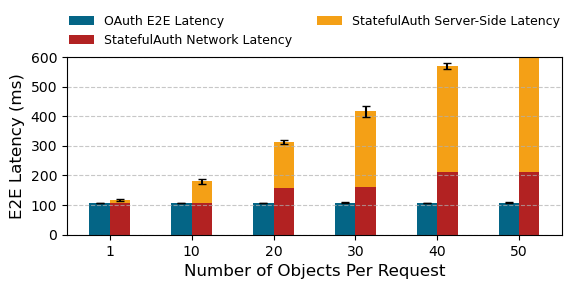

In [6]:
plot_latency(num_objects, avg_baseline, std_baseline, avg_stateful, std_stateful, breakdown_agg)

### Opt 1: In-memory DB

In [7]:
avg_stateful_in_memory, std_stateful_in_memory = get_latency('data/latency/t3/latency_stateful_in_memory.csv', warmup_steps=5)
breakdown_fp_in_memory = 'data/latency/t3/latency_breakdown_in_memory.txt'
breakdown_agg_in_memory = get_breakdown_data(breakdown_fp_in_memory, num_objects, 5)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Number of Objects Per Request', ylabel='E2E Latency (ms)'>)

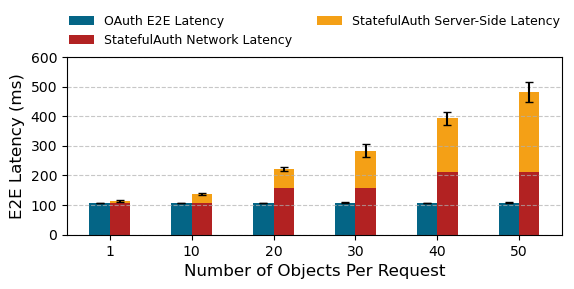

In [8]:
plot_latency(num_objects, avg_baseline, std_baseline, avg_stateful_in_memory, std_stateful_in_memory, breakdown_agg_in_memory)

### Opt 2: c5d w/ insertion on resource API

In [9]:
avg_baseline_c5d, std_baseline_c5d = get_latency('data/latency/c5d_insert/latency_baseline.csv', warmup_steps=5)
avg_stateful_c5d, std_stateful_c5d = get_latency('data/latency/c5d_insert/latency_stateful.csv', warmup_steps=5)
breakdown_fp_c5d = 'data/latency/c5d_insert/latency_breakdown.txt'
breakdown_agg_c5d = get_breakdown_data(breakdown_fp_c5d, num_objects, 5)

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Number of Objects Per Request', ylabel='E2E Latency (ms)'>)

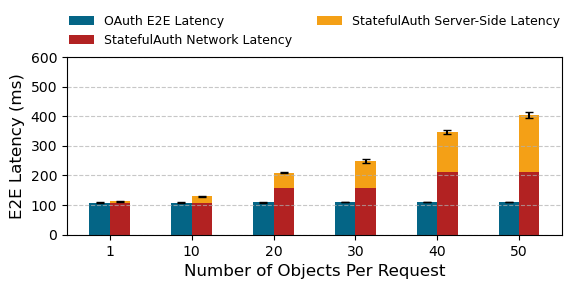

In [10]:
plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_c5d, std_stateful_c5d, breakdown_agg_c5d)

### Opt 3: Optimize serialization and deserialization of history data

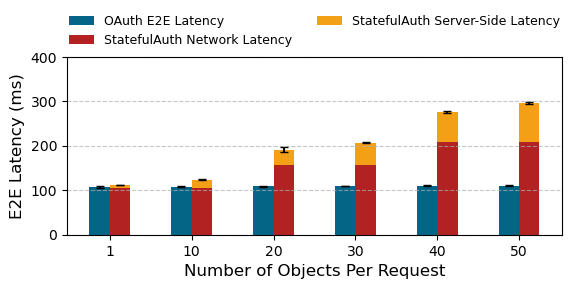

In [11]:
avg_stateful_c5d_opt, std_stateful_c5d_opt = get_latency('data/latency/c5d_insert/latency_stateful_01_30.csv', warmup_steps=5)
breakdown_fp_c5d_opt = 'data/latency/c5d_insert/latency_breakdown_01_30.txt'
breakdown_agg_c5d_opt = get_breakdown_data(breakdown_fp_c5d_opt, num_objects, 5)
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_c5d_opt, std_stateful_c5d_opt, breakdown_agg_c5d_opt)
ax.set_ylim(0, 400)
fig.savefig('plots/eval_e2e_latency_breakdown.png', dpi=300)

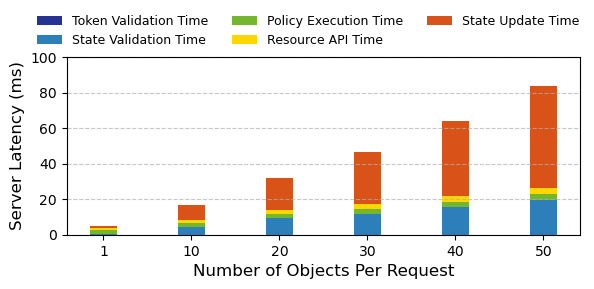

In [12]:
fig, ax = plot_breakdown(num_objects, avg_baseline_c5d, avg_stateful_c5d_opt, breakdown_agg_c5d_opt)
fig.savefig('plots/eval_stateful_server_breakdown.png', dpi=300)

### Design Update: WASM State Updater

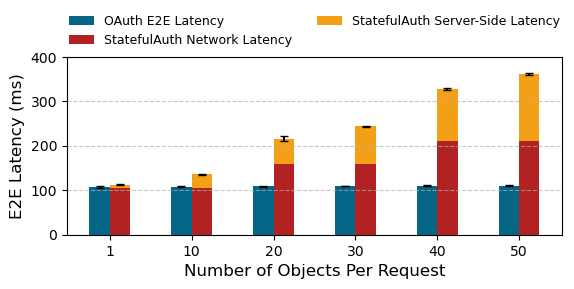

In [13]:
avg_stateful_updater, std_stateful_updater = get_latency('data/latency/c5d_insert/latency_stateful_updater.csv', warmup_steps=5)
breakdown_fp_updater = 'data/latency/c5d_insert/latency_breakdown_updater.txt'
breakdown_agg_updater = get_breakdown_data(breakdown_fp_updater, num_objects, 5)
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_updater, std_stateful_updater, breakdown_agg_updater)
ax.set_ylim(0, 400)
fig.savefig('plots/eval_e2e_latency_breakdown.png', dpi=300)

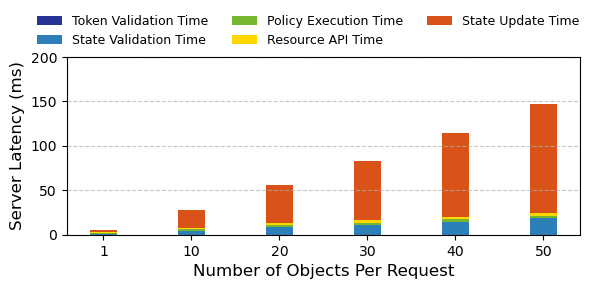

In [14]:
fig, ax = plot_breakdown(num_objects, avg_baseline_c5d, avg_stateful_updater, breakdown_agg_updater)
ax.set_ylim(0, 200)
fig.savefig('plots/eval_stateful_server_breakdown.png', dpi=300)

In [15]:
breakdown_agg_updater

{'request_total_time': [7.19139099121052,
  30.13552665710409,
  58.34837913513144,
  85.97705841064406,
  117.21435546874953,
  150.52399635314896],
 'token_validation_time': [0.020208358764648438,
  0.020656585693359375,
  0.022363662719726562,
  0.020856857299804688,
  0.021066665649414062,
  0.021495819091796875],
 'history_validation_time': [0.55211067199656,
  3.8947772979731203,
  8.563194274901798,
  11.146154403685962,
  14.848222732543444,
  18.511810302733885],
 'policy_execution_time': [1.77681922912552,
  1.97459220886184,
  2.2810745239252004,
  2.47003555297796,
  2.65798568725536,
  2.88049697875928],
 'history_update_time': [2.2797584533686,
  20.960083007812003,
  43.28280448913529,
  67.42082595825144,
  93.91828536987262,
  122.5011539459223],
 'resource_api_time': [1.0605716705318,
  1.51602745056104,
  1.9812107086177602,
  2.39598274230912,
  2.8511619567866004,
  3.3084869384760403]}

In [16]:
for n in num_objects:
    print(f'{n} objects: {avg_stateful_updater[n]}, {avg_baseline_c5d[n]}, {avg_stateful_updater[n] / avg_baseline_c5d[n] * 100 - 100:.2f}%')

1 objects: 112.75494575500488, 108.06414604187012, 4.34%
10 objects: 135.84760665893555, 108.00156593322754, 25.78%
20 objects: 216.41192436218262, 109.20148849487305, 98.18%
30 objects: 244.07084465026855, 109.65420722961426, 122.58%
40 objects: 327.48555183410645, 110.47202110290527, 196.44%
50 objects: 361.42147064208984, 110.45014381408691, 227.23%


In [17]:
for i, n in enumerate(num_objects):
    history_validation_portion = breakdown_agg_updater["history_validation_time"][i] / breakdown_agg_updater["request_total_time"][i] * 100
    history_update_portion = breakdown_agg_updater["history_update_time"][i] / breakdown_agg_updater["request_total_time"][i] * 100
    print(f'{n} objects: {history_validation_portion:.2f}% {history_update_portion:.2f}%')

1 objects: 7.68% 31.70%
10 objects: 12.92% 69.55%
20 objects: 14.68% 74.18%
30 objects: 12.96% 78.42%
40 objects: 12.67% 80.13%
50 objects: 12.30% 81.38%


## Conclusions
1. Extra latency on server grows linearly with the number of objects.
2. Extra latency on server VERY dependent (actually linearly) on DB operations.
3. We can optimize it by running multiple threads, which a real server will also do, just some engineering efforts.
4. But the first point still holds true.

### Opt 4: Loop inside Wasm + Replace hash w/ hmac

#### Ramdisk

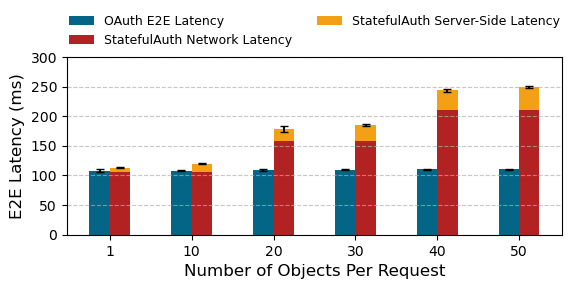

In [18]:
avg_stateful_wasm_loop_ramdisk, std_stateful_wasm_loop_ramdisk = get_latency('data/latency/c5d_insert/latency_stateful_05_15_hmac_ramdisk.csv', warmup_steps=5)
breakdown_fp_wasm_loop_ramdisk = 'data/latency/c5d_insert/latency_breakdown_05_15_hmac_ramdisk.txt'
breakdown_agg_wasm_loop_ramdisk = get_breakdown_data(breakdown_fp_wasm_loop_ramdisk, num_objects, 5)
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_wasm_loop_ramdisk, std_stateful_wasm_loop_ramdisk, breakdown_agg_wasm_loop_ramdisk)
ax.set_ylim(0, 300)
fig.savefig('plots/eval_e2e_latency_breakdown.png', dpi=300)

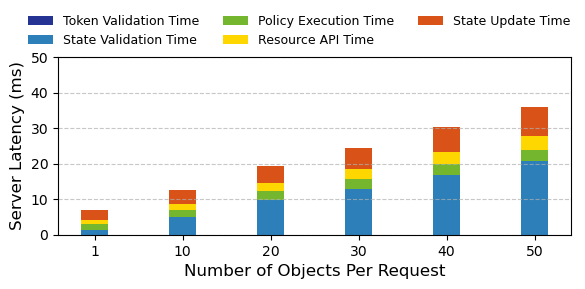

In [19]:
fig, ax = plot_breakdown(num_objects, avg_baseline_c5d, avg_stateful_wasm_loop_ramdisk, breakdown_agg_wasm_loop_ramdisk)
ax.set_ylim(0, 50)
fig.savefig('plots/eval_stateful_server_breakdown.png', dpi=300)

In [20]:
breakdown_agg_wasm_loop_ramdisk

{'request_total_time': [8.306818008422281,
  14.250822067260321,
  21.481342315673317,
  27.12057113647408,
  33.45857620239204,
  39.19778823852492],
 'token_validation_time': [0.01705169677734375,
  0.017719268798828125,
  0.018301010131835938,
  0.019979476928710934,
  0.0209808349609375,
  0.02033233642578125],
 'history_validation_time': [1.3064956665034,
  5.0005340576166395,
  9.783763885497601,
  12.817373275756323,
  16.804637908935,
  20.719623565673363],
 'policy_execution_time': [1.6220569610591205,
  2.0033931732173205,
  2.4199199676509204,
  2.78370857238724,
  3.01529884338324,
  3.2016849517818],
 'history_update_time': [2.90097236633244,
  3.9309597015376,
  5.011615753173361,
  6.140346527099081,
  7.214775085448801,
  8.10952186584416],
 'resource_api_time': [1.1018180847162402,
  1.65475845336864,
  2.20061302185,
  2.7749633789057597,
  3.33348274230904,
  3.79421234130804]}

In [21]:
for n in num_objects:
    print(f'{n} objects: {avg_stateful_wasm_loop_ramdisk[n]}, {avg_baseline_c5d[n]}, {avg_stateful_wasm_loop_ramdisk[n] / avg_baseline_c5d[n] * 100 - 100:.2f}%')

1 objects: 113.45969200134277, 108.06414604187012, 4.99%
10 objects: 119.81178283691406, 108.00156593322754, 10.94%
20 objects: 179.04285430908203, 109.20148849487305, 63.96%
30 objects: 185.43939590454102, 109.65420722961426, 69.11%
40 objects: 243.55502128601074, 110.47202110290527, 120.47%
50 objects: 249.32775497436523, 110.45014381408691, 125.74%


In [22]:
for i, n in enumerate(num_objects):
    history_validation_portion = breakdown_agg_wasm_loop_ramdisk["history_validation_time"][i] / breakdown_agg_wasm_loop_ramdisk["request_total_time"][i] * 100
    history_update_portion = breakdown_agg_wasm_loop_ramdisk["history_update_time"][i] / breakdown_agg_wasm_loop_ramdisk["request_total_time"][i] * 100
    print(f'{n} objects: {history_validation_portion:.2f}% {history_update_portion:.2f}%')

1 objects: 15.73% 34.92%
10 objects: 35.09% 27.58%
20 objects: 45.55% 23.33%
30 objects: 47.26% 22.64%
40 objects: 50.23% 21.56%
50 objects: 52.86% 20.69%


#### In-memory

(0.0, 300.0)

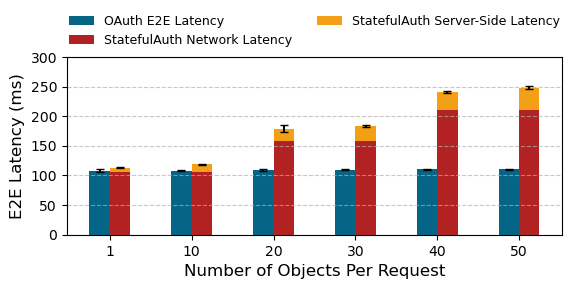

In [23]:
avg_stateful_wasm_loop_in_memory, std_stateful_wasm_loop_in_memory = get_latency('data/latency/c5d_insert/latency_stateful_05_17_hmac.csv', warmup_steps=5)
breakdown_fp_wasm_loop_in_memory = 'data/latency/c5d_insert/latency_breakdown_05_17_hmac.txt'
breakdown_agg_wasm_loop_in_memory = get_breakdown_data(breakdown_fp_wasm_loop_in_memory, num_objects, 5)
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_wasm_loop_in_memory, std_stateful_wasm_loop_in_memory, breakdown_agg_wasm_loop_in_memory)
ax.set_ylim(0, 300)
# fig.savefig('plots/eval_e2e_latency_breakdown.png', dpi=300)

(0.0, 40.0)

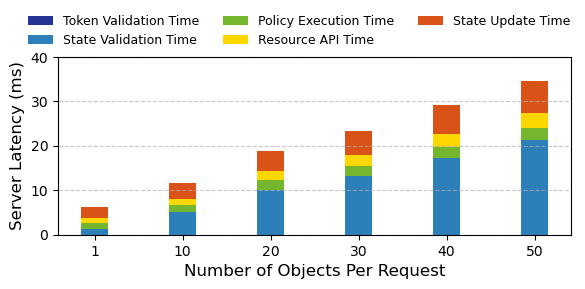

In [24]:
fig, ax = plot_breakdown(num_objects, avg_baseline_c5d, avg_stateful_wasm_loop_in_memory, breakdown_agg_wasm_loop_in_memory)
ax.set_ylim(0, 40)
# fig.savefig('plots/eval_stateful_server_breakdown.png', dpi=300)

In [25]:
breakdown_agg_wasm_loop_in_memory

{'request_total_time': [7.53085136413524,
  13.121623992919442,
  20.712394714354964,
  25.56609153747508,
  31.7596054077144,
  37.59911537170364],
 'token_validation_time': [0.01679420471191406,
  0.017814636230468747,
  0.019035339355468747,
  0.018997192382812497,
  0.019998550415039062,
  0.019140243530273434],
 'history_validation_time': [1.2348937988277202,
  5.03002166748004,
  10.137100219726081,
  13.16761016845656,
  17.2648811340328,
  21.351327896117805],
 'policy_execution_time': [1.48362159728956,
  1.6761302947992398,
  2.16633796691832,
  2.3012733459468406,
  2.5267601013178402,
  2.6851367950435203],
 'history_update_time': [2.6316738128656803,
  3.47600936889608,
  4.4691181182856,
  5.40869712829532,
  6.426992416381359,
  7.304649353026801],
 'resource_api_time': [0.9404754638666001,
  1.4117050170893601,
  1.9551753997798005,
  2.3841571807856803,
  2.8665161132806802,
  3.30034255981396]}

In [26]:
for n in num_objects:
    print(f'{n} objects: {avg_stateful_wasm_loop_in_memory[n]}, {avg_baseline_c5d[n]}, {avg_stateful_wasm_loop_in_memory[n] / avg_baseline_c5d[n] * 100 - 100:.2f}%')

1 objects: 112.90242195129395, 108.06414604187012, 4.48%
10 objects: 118.92210960388184, 108.00156593322754, 10.11%
20 objects: 178.5414981842041, 109.20148849487305, 63.50%
30 objects: 183.72143745422363, 109.65420722961426, 67.55%
40 objects: 241.58625602722168, 110.47202110290527, 118.69%
50 objects: 248.3205509185791, 110.45014381408691, 124.83%


In [27]:
for i, n in enumerate(num_objects):
    history_validation_portion = breakdown_agg_wasm_loop_in_memory["history_validation_time"][i] / breakdown_agg_wasm_loop_in_memory["request_total_time"][i] * 100
    history_update_portion = breakdown_agg_wasm_loop_in_memory["history_update_time"][i] / breakdown_agg_wasm_loop_in_memory["request_total_time"][i] * 100
    print(f'{n} objects: {history_validation_portion:.2f}% {history_update_portion:.2f}%')

1 objects: 16.40% 34.95%
10 objects: 38.33% 26.49%
20 objects: 48.94% 21.58%
30 objects: 51.50% 21.16%
40 objects: 54.36% 20.24%
50 objects: 56.79% 19.43%


## Optimization Summary

In [28]:
def to_array(d):
    if isinstance(d, dict):
        return np.array(list(d.values()))
    elif isinstance(d, list):
        return np.array(d)
    else:
        return d

In [29]:
(to_array(avg_stateful_updater) - to_array(avg_stateful_wasm_loop_in_memory)) / to_array(avg_stateful_updater) * 100

array([-0.13079355, 12.45917942, 17.49923267, 24.72618443, 26.22994979,
       31.29335939])

In [30]:
breakdown_agg_updater['request_total_time']

[7.19139099121052,
 30.13552665710409,
 58.34837913513144,
 85.97705841064406,
 117.21435546874953,
 150.52399635314896]

In [31]:
to_array(breakdown_agg_updater['request_total_time']) / to_array(breakdown_agg_wasm_loop_in_memory['request_total_time'])

array([0.95492404, 2.29663086, 2.81707547, 3.36293322, 3.69067417,
       4.00339196])

## Comparison hash- and hmac-based design

In [32]:
def plot_latency_comp(num_objects, avg_baseline, std_baseline, avg_stateful_1, std_stateful_1, breakdown_agg_1, avg_stateful_2, std_stateful_2, breakdown_agg_2):

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar_1 = np.array(list(avg_stateful_1.values()))
    stateful_bar_2 = np.array(list(avg_stateful_2.values()))

    # Error bars
    baseline_error = np.array(list(std_baseline.values()))  # Replace [...] with your error values for baseline_bar
    stateful_error_1 = np.array(list(std_stateful_1.values()))  # Replace [...] with your error values for stateful_bar
    stateful_error_2 = np.array(list(std_stateful_2.values()))

    # Set up positions for bars
    bar_width = 0.2

    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3.5))
    colors = ['#ac92eb', '#2c7fb8', '#74b72e', '#ffd700', '#D95319']
    # Add e2e latency bars
    bar1 = ax.bar(index - bar_width, baseline_bar, bar_width, label='OAuth E2E Latency', color=colors[4])

    # Add breakdown
    network_latency_1 = stateful_bar_1 - breakdown_agg_1['request_total_time']
    network_latency_2 = stateful_bar_2 - breakdown_agg_2['request_total_time']
    # bottom = np.zeros(len(baseline_bar))
    # ax.bar(index + bar_width / 2, baseline_bar, bar_width, bottom=bottom, label=f'Baseline')
    bar3 = ax.bar(index, network_latency_1, bar_width, bottom=np.zeros(len(network_latency_1)), label=f'StatefulAuth Network Latency (Hash)', color=colors[3])
    bar2 = ax.bar(index, breakdown_agg_1['request_total_time'], bar_width, bottom=network_latency_1, label='StatefulAuth Server-Side Latency (Hash)', color=colors[2])

    bar5 = ax.bar(index + bar_width, stateful_bar_2, bar_width, label='StatefulAuth Network Latency (HMAC)', color=colors[1])
    bar4 = ax.bar(index + bar_width, breakdown_agg_2['request_total_time'], bar_width, bottom=network_latency_2, label='StatefulAuth Server-Side Latency (HMAC)', color=colors[0])
    
    # Print the data I need
    print('Hash:', (network_latency_1 - baseline_bar) / (stateful_bar_1 - baseline_bar) * 100)
    print('HMAC:', (network_latency_2 - baseline_bar) / (stateful_bar_1 - baseline_bar) * 100)

    # handles = [bar1, bar2, bar3, bar4, bar5]
    # labels = ['OAuth E2E Latency', 'StatefulAuth Server-Side Latency (Hash)', 'StatefulAuth Network Latency (Hash)',
    #           'StatefulAuth Server-Side Latency (HMAC)', 'StatefulAuth Network Latency (HMAC)']

    handles, labels = ax.get_legend_handles_labels()
    # Move legend above the plot
    ax.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(-0.08, 1.05, 1.1, 0.3), frameon=False, shadow=True, fontsize=8.5, mode="expand")

    # Add error bars
    ax.errorbar(index - bar_width, baseline_bar, yerr=baseline_error, fmt='none', capsize=3, color='black', label='Error Bar (OAuth)')
    ax.errorbar(index, stateful_bar_1, yerr=stateful_error_1, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth Hash)')
    ax.errorbar(index + bar_width, stateful_bar_2, yerr=stateful_error_2, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth HMAC)')


    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('E2E Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 600)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/e2e_latency_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()

    return fig, ax


In [33]:
avg_stateful_hmac, std_stateful_hmac = get_latency('data/latency/c5d_insert/latency_stateful_05_17_hmac.csv', warmup_steps=5)
breakdown_fp_hmac = 'data/latency/c5d_insert/latency_breakdown_05_17_hmac.txt'
avg_stateful_hash, std_stateful_hash = get_latency('data/latency/c5d_insert/latency_stateful_05_17_hash.csv', warmup_steps=5)
breakdown_fp_hash = 'data/latency/c5d_insert/latency_breakdown_05_17_hash.txt'

Hash: [-70.80715844 -26.84414561  72.00933122  67.0481445   76.95285812
  73.47580265]
HMAC: [-70.94536189 -23.34291121  72.27871569  68.06127895  76.21587918
  73.36619512]


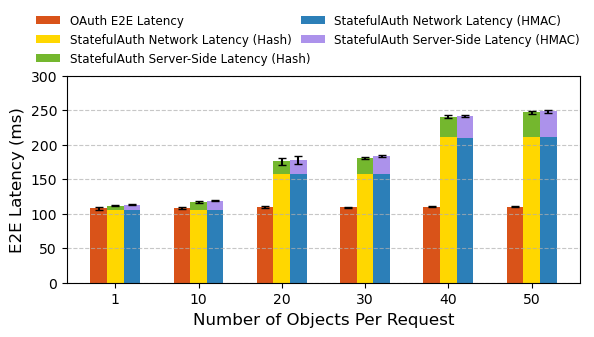

In [34]:
breakdown_agg_hmac = get_breakdown_data(breakdown_fp_hmac, num_objects, 5)
breakdown_agg_hash = get_breakdown_data(breakdown_fp_hash, num_objects, 5)
fig, ax = plot_latency_comp(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_hash, std_stateful_hash, breakdown_agg_hash, avg_stateful_hmac, std_stateful_hmac, breakdown_agg_hmac)
ax.set_ylim(0, 300)
fig.savefig('plots/eval_e2e_latency_breakdown_comp.png', dpi=300)

In [35]:
def plot_latency_comp_3(num_objects, avg_baseline, std_baseline, avg_stateful_1, std_stateful_1, breakdown_agg_1, avg_stateful_2, std_stateful_2, breakdown_agg_2, avg_stateful_3, std_stateful_3, breakdown_agg_3):

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar_1 = np.array(list(avg_stateful_1.values()))
    stateful_bar_2 = np.array(list(avg_stateful_2.values()))
    stateful_bar_3 = np.array(list(avg_stateful_3.values()))

    # Error bars
    baseline_error = np.array(list(std_baseline.values()))  # Replace [...] with your error values for baseline_bar
    stateful_error_1 = np.array(list(std_stateful_1.values()))  # Replace [...] with your error values for stateful_bar
    stateful_error_2 = np.array(list(std_stateful_2.values()))
    stateful_error_3 = np.array(list(std_stateful_3.values()))

    # Set up positions for bars
    bar_width = 0.12

    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3.6))
    colors = ['#800000', '#f58231', '#a9a9a9', '#ffd700', '#74b72e', '#2c7fb8', '#ac92eb']
    # Add e2e latency bars
    bar1 = ax.bar(index - bar_width / 2 * 3, baseline_bar, bar_width, label='OAuth E2E Latency', color=colors[0])

    # Add breakdown
    network_latency_1 = stateful_bar_1 - breakdown_agg_1['request_total_time']
    network_latency_2 = stateful_bar_2 - breakdown_agg_2['request_total_time']
    network_latency_3 = stateful_bar_3 - breakdown_agg_3['request_total_time']
    # bottom = np.zeros(len(baseline_bar))
    # ax.bar(index + bar_width / 2, baseline_bar, bar_width, bottom=bottom, label=f'Baseline')
    bar3 = ax.bar(index - bar_width / 2, network_latency_1, bar_width, bottom=np.zeros(len(network_latency_1)), label=f'StatefulAuth Network Latency (Pre-Opt Hash)', color=colors[1])
    bar2 = ax.bar(index - bar_width / 2, breakdown_agg_1['request_total_time'], bar_width, bottom=network_latency_1, label='StatefulAuth Server-Side Latency (Pre-Opt Hash)', color=colors[2])

    bar5 = ax.bar(index + bar_width / 2, stateful_bar_2, bar_width, label='StatefulAuth Network Latency (Hash)', color=colors[3])
    bar4 = ax.bar(index + bar_width / 2, breakdown_agg_2['request_total_time'], bar_width, bottom=network_latency_2, label='StatefulAuth Server-Side Latency (Hash)', color=colors[4])

    bar7 = ax.bar(index + bar_width / 2 * 3, stateful_bar_3, bar_width, label='StatefulAuth Network Latency (HMAC)', color=colors[5])
    bar6 = ax.bar(index + bar_width / 2 * 3, breakdown_agg_3['request_total_time'], bar_width, bottom=network_latency_3, label='StatefulAuth Server-Side Latency (HMAC)', color=colors[6])

    # Move legend above the plot
    ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(-0.15, 1.05, 1.2, 0.4), frameon=False, shadow=True, fontsize=8.3, mode="expand")
    # (-0.15, 1.05, 1.2, 0.5)
    # Add error bars
    ax.errorbar(index - bar_width / 2 * 3, baseline_bar, yerr=baseline_error, fmt='none', capsize=3, color='black', label='Error Bar (OAuth)')
    ax.errorbar(index - bar_width / 2, stateful_bar_1, yerr=stateful_error_1, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth Pre-Opt Hash)')
    ax.errorbar(index + bar_width / 2, stateful_bar_2, yerr=stateful_error_2, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth Hash)')
    ax.errorbar(index + bar_width / 2 * 3, stateful_bar_3, yerr=stateful_error_3, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth HMAC)')


    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('E2E Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 600)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/e2e_latency_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()

    return fig, ax


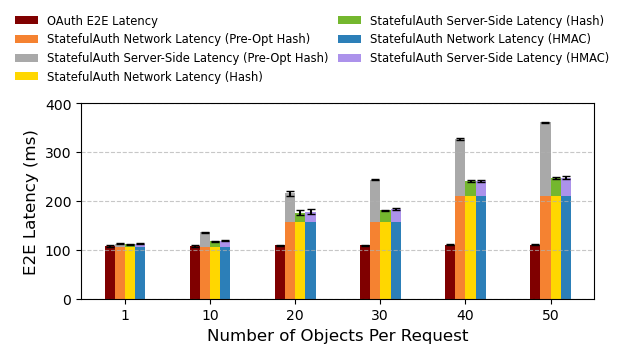

In [36]:
fig, ax = plot_latency_comp_3(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_updater, std_stateful_updater, breakdown_agg_updater, avg_stateful_hash, std_stateful_hash, breakdown_agg_hash, avg_stateful_hmac, std_stateful_hmac, breakdown_agg_hmac)
ax.set_ylim(0, 400)
fig.savefig('plots/eval_e2e_latency_breakdown_comp_new.png', dpi=300)

In [37]:
def plot_breakdown_comp(num_objects, avg_baseline, avg_stateful_1, breakdown_agg_1, avg_stateful_2, breakdown_agg_2):

    # server_latency = np.array(breakdown_agg['request_total_time'])

    # Set up positions for bars
    bar_width = 0.3
    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # Add e2e latency bars
    # bar1 = ax.bar(index, server_latency, bar_width, label='Server-Side Latency')

    keys = ['token_validation_time', 'history_validation_time', 'policy_execution_time', 'resource_api_time', 'history_update_time']
    labels = ['Token Validation Time', 'State Validation Time', 'Policy Execution Time', 'Resource API Time', 'State Update Time']
    breakdown_data = [
        [np.array(breakdown_agg_1[key]) for key in keys],
        [np.array(breakdown_agg_2[key]) for key in keys]
    ]
    colors = ['#253494', '#2c7fb8', '#74b72e', '#ffd700', '#D95319']
    for k, x in enumerate([index-bar_width/2, index+bar_width/2]):
        bottom = None
        for i, breakdown in enumerate(breakdown_data[k]):
            if bottom is None:
                bottom = np.zeros(len(breakdown))
            else:
                bottom += breakdown_data[k][i - 1]
            print(i, k, breakdown, bottom)
            ax.bar(x, breakdown, bar_width, bottom=bottom, label=labels[i], color=colors[i])

    # Move legend above the plot
    ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(-0.08, 1, 1.1, 0.3), frameon=False, fontsize=9, mode="expand",)

    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('Server Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 100)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('server-side_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()
    return fig, ax


0 0 [0.01675606 0.01750946 0.01867294 0.01662254 0.01893997 0.01968384] [0. 0. 0. 0. 0. 0.]
1 0 [ 0.55007935  4.25053596  9.16155815 12.08673477 16.14844322 20.1993084 ] [0.01675606 0.01750946 0.01867294 0.01662254 0.01893997 0.01968384]
2 0 [1.48330688 1.67788506 1.98154449 2.13090897 2.54959106 2.79920578] [ 0.5668354   4.26804543  9.18023109 12.10335732 16.16738319 20.21899223]
3 0 [0.93102455 1.39940262 1.86120033 2.27826118 2.81200409 3.31374168] [ 2.05014229  5.94593048 11.16177559 14.23426628 18.71697426 23.01819801]
4 0 [2.26895332 3.09444427 3.96561623 4.8220253  5.8721447  6.83056831] [ 2.98116684  7.3453331  13.02297592 16.51252747 21.52897835 26.3319397 ]
0 1 [0.0167942  0.01781464 0.01903534 0.01899719 0.01999855 0.01914024] [0. 0. 0. 0. 0. 0.]
1 1 [ 1.2348938   5.03002167 10.13710022 13.16761017 17.26488113 21.3513279 ] [0.0167942  0.01781464 0.01903534 0.01899719 0.01999855 0.01914024]
2 1 [1.4836216  1.67613029 2.16633797 2.30127335 2.5267601  2.6851368 ] [ 1.251688    

(0.0, 40.0)

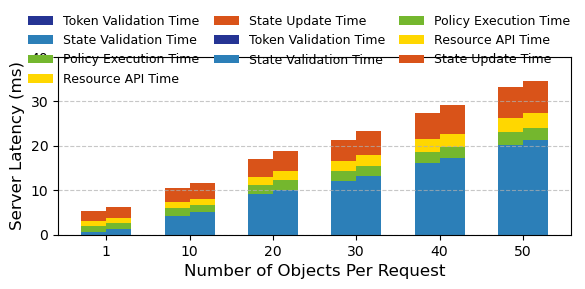

In [38]:
fig, ax = plot_breakdown_comp(num_objects, avg_baseline_c5d, avg_stateful_hash, breakdown_agg_hash, avg_stateful_hmac, breakdown_agg_hmac)
ax.set_ylim(0, 40)

## Stateless Comparison

In [39]:
def parse_stateless(filepath):
    df = pd.read_csv(filepath)
    avg_macaroon, std_macaroon = [df['macaroon_e2e'].mean(), df['macaroon_e2e_deny'].mean()], [df['macaroon_e2e'].std(), df['macaroon_e2e_deny'].std()]
    avg_stateful, std_stateful = [df['stateful_e2e'].mean(), df['stateful_e2e_deny'].mean()], [df['stateful_e2e'].std(), df['stateful_e2e_deny'].std()]
    avg_macaroon_server = [df['macaroon_server'].mean(), df['macaroon_server_deny'].mean()]
    avg_stateful_server = [df['stateful_server'].mean(), df['stateful_server_deny'].mean()]
    return avg_macaroon, std_macaroon, avg_stateful, std_stateful, avg_macaroon_server, avg_stateful_server

In [40]:
def plot_latency_comp_stateless(xs, avg_baseline, std_baseline, server_baseline, avg_stateful, std_stateful, server_stateful):

    baseline_bar = np.array(list(avg_baseline))
    stateful_bar = np.array(list(avg_stateful))

    # Error bars
    baseline_error = np.array(list(std_baseline))
    stateful_error = np.array(list(std_stateful))

    # Set up positions for bars
    bar_width = 0.25

    index = np.arange(len(xs))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))
    colors = ['#ac92eb', '#2c7fb8', '#74b72e', '#ffd700', '#D95319']
    # Add e2e latency bars
    # bar1 = ax.bar(index - bar_width, baseline_bar, bar_width, label='OAuth E2E Latency', color=colors[4])

    # Add breakdown
    baseline_network_latency = baseline_bar - server_baseline
    stateful_network_latency= stateful_bar - server_stateful
    # bottom = np.zeros(len(baseline_bar))
    # ax.bar(index + bar_width / 2, baseline_bar, bar_width, bottom=bottom, label=f'Baseline')
    bar3 = ax.bar(index - bar_width / 2, baseline_network_latency, bar_width, label=f'Macaroons Network Latency', color=colors[3])
    bar2 = ax.bar(index - bar_width / 2, server_baseline, bar_width, bottom=baseline_network_latency, label='Macaroons Server-Side Latency', color=colors[2])

    bar5 = ax.bar(index + bar_width / 2, stateful_network_latency, bar_width, label='StatefulAuth Network Latency', color=colors[1])
    bar4 = ax.bar(index + bar_width / 2, server_stateful, bar_width, bottom=stateful_network_latency, label='StatefulAuth Server-Side Latency', color=colors[0])
    
    # Move legend above the plot
    # ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(-0.08, 1.05, 1.1, 0.3), frameon=False, shadow=True, fontsize=8.5, mode="expand")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.4, 1, 0.3), frameon=False, shadow=True, fontsize=9)

    # Add error bars
    ax.errorbar(index - bar_width / 2, baseline_bar, yerr=baseline_error, fmt='none', capsize=3, color='black', label='Error Bar (Macaroon)')
    ax.errorbar(index + bar_width / 2, stateful_bar, yerr=stateful_error, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth)')


    ax.set_xlabel('Policy Execution Result', fontsize=12)
    ax.set_ylabel('E2E Latency (ms)', fontsize=12)

    # Set margin for x-axis
    margin = 0.65
    ax.set_xlim(-margin, len(xs) - 1 + margin)

    ax.set_xticks(index)
    ax.set_xticklabels(xs, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 600)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 1])  # Set the rect parameter to adjust the layout and avoid cropping the legenda

    return fig, ax


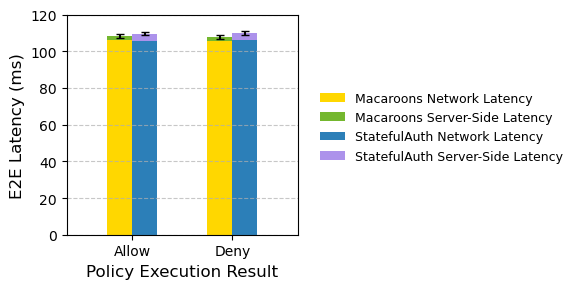

In [41]:
avg_macaroon, std_macaroon, avg_stateful, std_stateful, avg_macaroon_server, avg_stateful_server = parse_stateless('data/latency/c5d_insert/latency_stateless_comparison.csv')
fig, ax = plot_latency_comp_stateless(['Allow', 'Deny'], avg_macaroon, std_macaroon, avg_macaroon_server, avg_stateful, std_stateful, avg_stateful_server)
ax.set_ylim(0, 120)
fig.savefig('plots/eval_stateless_comp.png', dpi=300)

# USENIX Presentation Plots

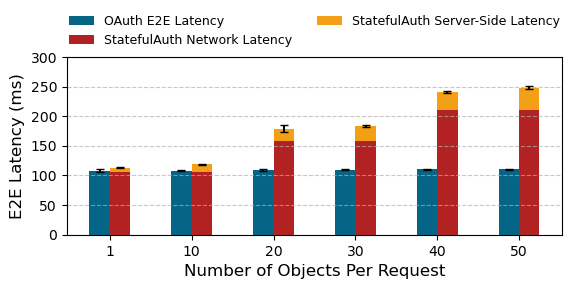

In [59]:
fig, ax = plot_latency(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_hmac, std_stateful_hmac, breakdown_agg_hmac)
ax.set_ylim(0, 300)
fig.savefig('plots/eval_usenix.png', dpi=300)

In [60]:
def plot_latency_first_bar_only(num_objects, avg_baseline, std_baseline, avg_stateful, std_stateful, breakdown_agg):

    # Set all the bars except for the first one to zero
    avg_baseline = {k: 0 if i > 0 else v for i, (k, v) in enumerate(avg_baseline.items())}
    std_baseline = {k: 0 if i > 0 else v for i, (k, v) in enumerate(std_baseline.items())}
    avg_stateful = {k: 0 if i > 0 else v for i, (k, v) in enumerate(avg_stateful.items())}
    std_stateful = {k: 0 if i > 0 else v for i, (k, v) in enumerate(std_stateful.items())}
    breakdown_agg = {k: [0 if i > 0 else v for i, v in enumerate(breakdown_agg[k])] for k in breakdown_agg}

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar = np.array(list(avg_stateful.values()))

    # Error bars
    baseline_error = np.array(list(std_baseline.values()))  # Replace [...] with your error values for baseline_bar
    stateful_error = np.array(list(std_stateful.values()))  # Replace [...] with your error values for stateful_bar

    # Set up positions for bars
    bar_width = 0.25

    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # Add e2e latency bars
    bar1 = ax.bar(index - bar_width/2, baseline_bar, bar_width, label='OAuth E2E Latency', color="#046586")

    # Add breakdown
    network_latency = stateful_bar - breakdown_agg['request_total_time']
    # bottom = np.zeros(len(baseline_bar))
    # ax.bar(index + bar_width / 2, baseline_bar, bar_width, bottom=bottom, label=f'Baseline')
    bar3 = ax.bar(index + bar_width / 2, network_latency, bar_width, bottom=np.zeros(len(network_latency)), label=f'StatefulAuth Network Latency', color="#b22222")
    bar2 = ax.bar(index + bar_width/2, breakdown_agg['request_total_time'], bar_width, bottom=network_latency, label='StatefulAuth Server-Side Latency', color="#f4a016")

    # Move legend above the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, shadow=True, fontsize=9)

    # Add error bars
    ax.errorbar(index - bar_width/2, baseline_bar, yerr=baseline_error, fmt='none', capsize=3, color='black', label='Error Bar (OAuth)')
    ax.errorbar(index + bar_width/2, stateful_bar, yerr=stateful_error, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth)')

    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('E2E Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 600)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/e2e_latency_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()

    return fig, ax


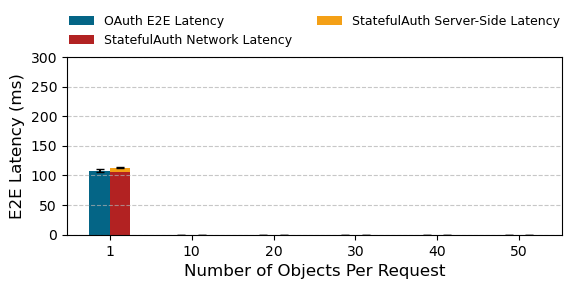

In [62]:
fig, ax = plot_latency_first_bar_only(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_hmac, std_stateful_hmac, breakdown_agg_hmac)
ax.set_ylim(0, 300)
fig.savefig('plots/eval_usenix_first_bar_only.png', dpi=300)

In [63]:
def plot_latency_no_bar(num_objects, avg_baseline, std_baseline, avg_stateful, std_stateful, breakdown_agg):

    # Set all the bars to zero
    avg_baseline = {k: 0 for k in avg_baseline}
    std_baseline = {k: 0 for k in std_baseline}
    avg_stateful = {k: 0 for k in avg_stateful}
    std_stateful = {k: 0 for k in std_stateful}
    breakdown_agg = {k: [0 for _ in v] for k, v in breakdown_agg.items()}

    baseline_bar = np.array(list(avg_baseline.values()))
    stateful_bar = np.array(list(avg_stateful.values()))

    # Error bars
    baseline_error = np.array(list(std_baseline.values()))  # Replace [...] with your error values for baseline_bar
    stateful_error = np.array(list(std_stateful.values()))  # Replace [...] with your error values for stateful_bar

    # Set up positions for bars
    bar_width = 0.25

    index = np.arange(len(num_objects))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # Add e2e latency bars
    bar1 = ax.bar(index - bar_width/2, baseline_bar, bar_width, label='OAuth E2E Latency', color="#046586")

    # Add breakdown
    network_latency = stateful_bar - breakdown_agg['request_total_time']
    # bottom = np.zeros(len(baseline_bar))
    # ax.bar(index + bar_width / 2, baseline_bar, bar_width, bottom=bottom, label=f'Baseline')
    bar3 = ax.bar(index + bar_width / 2, network_latency, bar_width, bottom=np.zeros(len(network_latency)), label=f'StatefulAuth Network Latency', color="#b22222")
    bar2 = ax.bar(index + bar_width/2, breakdown_agg['request_total_time'], bar_width, bottom=network_latency, label='StatefulAuth Server-Side Latency', color="#f4a016")

    # Move legend above the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, shadow=True, fontsize=9)

    # Add error bars
    ax.errorbar(index - bar_width/2, baseline_bar, yerr=baseline_error, fmt='none', capsize=3, color='black', label='Error Bar (OAuth)')
    ax.errorbar(index + bar_width/2, stateful_bar, yerr=stateful_error, fmt='none', capsize=3, color='black', label='Error Bar (StatefulAuth)')

    ax.set_xlabel('Number of Objects Per Request', fontsize=12)
    ax.set_ylabel('E2E Latency (ms)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(num_objects, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 600)  # Set y-axis limit for better visualization

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/e2e_latency_breakdown.png', dpi=300)

    # Show the plot
    # plt.show()

    return fig, ax


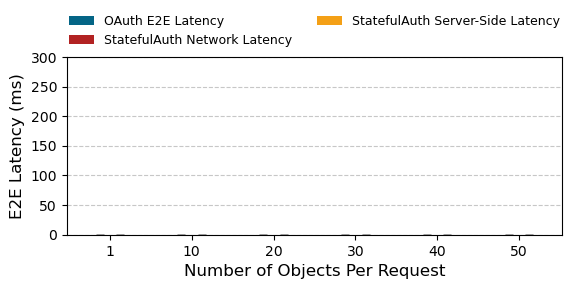

In [64]:
fig, ax = plot_latency_no_bar(num_objects, avg_baseline_c5d, std_baseline_c5d, avg_stateful_hmac, std_stateful_hmac, breakdown_agg_hmac)
ax.set_ylim(0, 300)
fig.savefig('plots/eval_usenix_no_bar.png', dpi=300)

# Throughput Comparison

In [42]:
import os
def get_tputs(folderpath, model='stateful'):
    tputs = {}
    for n_process in [1, 2, 4, 8, 16, 32, 64, 128]:
        files = [f for f in os.listdir(folderpath) if f.startswith(f'tput_{model}_{n_process}_')]
        if len(files) == 0:
            break
        global_tput = 0
        for f in files:
            with open(os.path.join(folderpath, f), 'r') as fp:
                df = pd.read_csv(fp)
                local_tput = df['tput'].median()
                global_tput += local_tput
        tputs[n_process] = global_tput
    return tputs

In [43]:
def plot_tputs(baseline_tputs, stateful_tputs, n_columns=4):

    # Sample data (replace this with your actual data)
    # n = min(len(baseline_tputs), len(stateful_tputs))
    xs = [2 ** i for i in range(0, n_columns)]
    baseline_tputs = [baseline_tputs[x] for x in xs]
    stateful_tputs = [stateful_tputs[x] for x in xs]

    # Set up positions for bars
    bar_width = 0.3  # Adjust the bar width for a two-bar comparison
    index = np.arange(len(xs))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 3))

    # alpha=0.95
    bar1 = ax.bar(index - bar_width/2, baseline_tputs, bar_width, label='OAuth', color='#046586')
    bar2 = ax.bar(index + bar_width/2, stateful_tputs, bar_width, label='StatefulAuth', color='#B22222')

    ax.set_xlabel('Number of Processes', fontsize=12)
    ax.set_ylabel('Throughput (req/s)', fontsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(xs, fontsize=10)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.6])
    # Move legend above the plot
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=False)

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 200)  # Set y-axis limit for better visualization

    # Add data labels at the middle of each bar
    for bars in [bar1, bar2]:
        for bar in bars:
            if bar.get_height() != 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                        f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10, color='black')

    fig.tight_layout(rect=[0, 0, 1, 0.9])  # Set the rect parameter to adjust the layout and avoid cropping the legend

    # Save the plot as a high-quality image (optional)
    # fig.savefig('plots/throughput_comparison.png', dpi=300)

    # Show the plot
    plt.show()


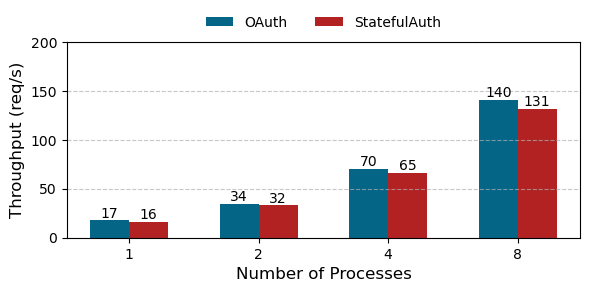

In [44]:
baseline_tputs = get_tputs('data/tput/baseline_insert/1_obj', model='baseline')
stateful_tputs = get_tputs('data/tput/stateful_insert/1_obj', model='stateful')
plot_tputs(baseline_tputs, stateful_tputs, n_columns=4)

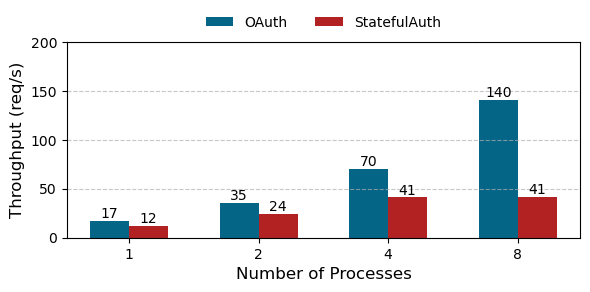

In [45]:
baseline_tputs_10_objs = get_tputs('data/tput/baseline_insert/10_obj/', model='baseline')
stateful_tputs_10_objs = get_tputs('data/tput/stateful_insert/10_obj/', model='stateful')
plot_tputs(baseline_tputs_10_objs, stateful_tputs_10_objs, n_columns=4)

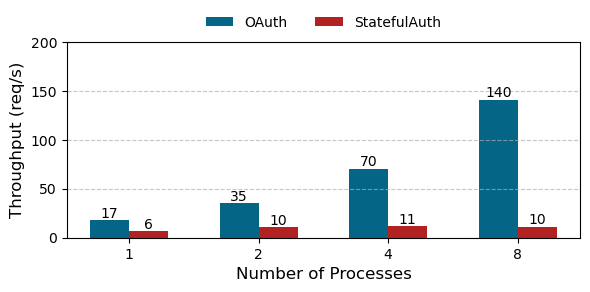

In [46]:
baseline_tputs_30_objs = get_tputs('data/tput/baseline_insert/30_obj/', model='baseline')
stateful_tputs_30_objs = get_tputs('data/tput/stateful_insert/30_obj/', model='stateful')
plot_tputs(baseline_tputs_30_objs, stateful_tputs_30_objs, n_columns=4)

### Opt: Optimize serialization and deserialization of history

In [48]:
baseline_tputs

{1: 17.685891468103584,
 2: 34.96588165405399,
 4: 70.30658627786363,
 8: 140.46465360060225,
 16: 278.2297922175132,
 32: 524.374617953686,
 64: 536.1260866278577,
 128: 535.6548850524525}

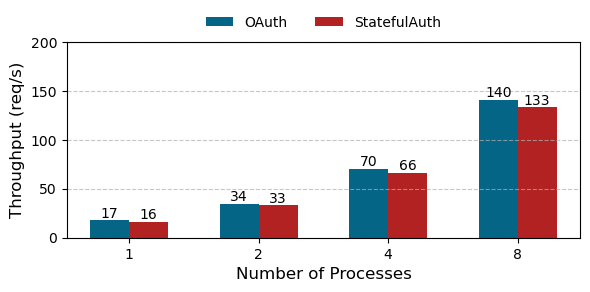

In [49]:
stateful_tputs_opt = get_tputs('data/tput/stateful_01_30/1_obj', model='stateful')
plot_tputs(baseline_tputs, stateful_tputs_opt, n_columns=4)

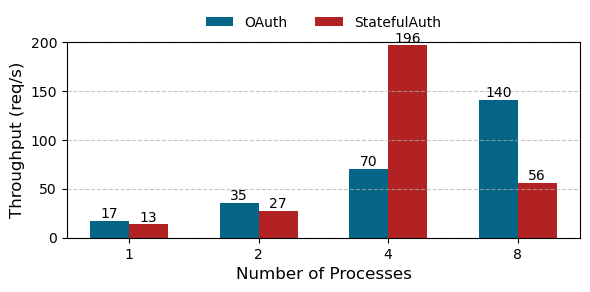

In [50]:
stateful_tputs_10_objs_opt = get_tputs('data/tput/stateful_01_30/10_obj/', model='stateful')
plot_tputs(baseline_tputs_10_objs, stateful_tputs_10_objs_opt, n_columns=4)

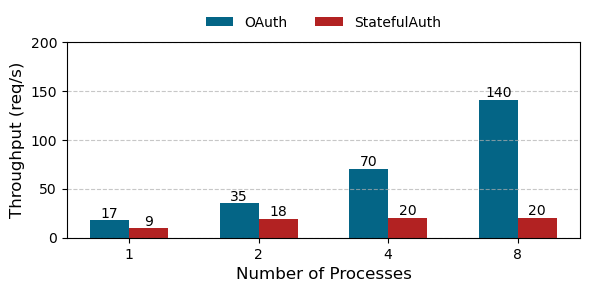

In [51]:
stateful_tputs_30_objs_opt = get_tputs('data/tput/stateful_01_30/30_obj/', model='stateful')
plot_tputs(baseline_tputs_30_objs, stateful_tputs_30_objs_opt, n_columns=4)